#  E-commerce Business Transaction Analysis

This notebook provides a comprehensive analysis of e-commerce transaction data including:
- Data cleaning and preprocessing
- Exploratory data analysis (EDA)
- Product category analysis
- Customer segmentation using RFM analysis
- Cohort analysis for customer retention insights

---


##  1. Import Libraries & Functions

In [41]:
#Data Manipulation
import pandas as pd
import numpy as np
import re

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

#RFM
from fim import arules
from operator import attrgetter

# Configuration
import warnings
warnings.filterwarnings("ignore")

#Kaggle data
from kaggle_data_download import download_dataset

### Functions

In [42]:
def check_numeric_cols(data: pd.DataFrame, rows: int, cols: int) -> None:
    '''
    Check the distribution for every numeric column of a dataframe using violin plots
    '''
#    Keep only numeric columns
    numeric_cols = data.select_dtypes(include='number').columns

#   Initiate plot
    fig, ax = plt.subplots(rows, cols, figsize=(8, 4))
    ax = ax.flatten()
    colors = plt.cm.tab20.colors  # list of 20 colors

    for i, col in list(enumerate(numeric_cols)):
        sns.violinplot(y=data[col].dropna(), ax=ax[i], color=colors[i % len(colors)], inner='quartile')
        ax[i].set_title(col)
        ax[i].set_xlabel(''); ax[i].set_ylabel('Value')
        if not i % rows: ax[i].set_xlabel('Value')
        if i > rows*(cols-1): ax[i].set_ylabel('Counts')

    fig.suptitle('Histograms of Numeric Features', fontsize=16)
    fig.tight_layout()
    
    plt.show()
    
def categorize_product(product_name: str) -> str:
    '''
    This function categorizes products into predefined categories based on their names using regex.
    '''
    
    if pd.isna(product_name):
        return 'Unknown'
    product_lower = str(product_name).lower()
    
    cases = [
    (r'(cushion|pillow|lamp|light|candle|holder|frame|mirror|clock|vase|decoration|ornament|decor|furniture|curtain|blind|drawer|cabinet|stand|lights|bed|\bdoily chalk\b|bell|card|candle )', 'Home Decor'),
    (r'(mug|cup|plate|bowl|kitchen|dining|spoon|fork|knife|tableware|cutlery|pot|pan|jug|saucer|regency|bottle|glass|coaster|cake|baking|jam|jar|breakfast)', 'Kitchen & Dining'),
    (r'(pen|notebook|paper|card|sticker|bookmark|diary|journal|planner|envelope|letter|message|pencils|ruler)', 'Stationery & Office'),
    (r'(shirt|dress|scarf|hat|glove|sock|fabric|textile|clothing|wear|apparel|top|bottom|outfit|sew)', 'Clothing & Textiles'),
    (r'(bag|tote|purse|wallet|case|pouch|handbag|backpack|luggage|lunch|shopper|jumbo|retrospot|polkadot)', 'Bags & Accessories'),
    (r'(food|snack|chocolate|sweet|candy|biscuit|edible|treats|consumable|drink|beverage|alcohol|jam|honey|sauce|\btea\b|\bcoffee\b)', 'Food & Consumables'),
    (r'(christmas|xmas|santa|advent|holiday|festive|seasonal|ludo)', 'Christmas & Holiday'),
    (r'(toy|game|puzzle|doll|teddy|bear|play|figurine|model)', 'Toys & Games'),
    (r'(garden|outdoor|plant|flower|seed|pot|herb|gardening|watering|greenhouse)', 'Garden & Outdoor'),
    (r'(gift|present|wrap|bag)', 'Gift & Wrapping'),
    (r'(tool|hardware|screw|tape|scissors|clip|peg)', 'Tools & Hardware'),
    (r'(beauty|soap|bath|cosmetic|makeup|perfume|lotion|hair|necklace|bracelet)', 'Beauty & Personal Care'),
    (r'(pet|dog|cat|animal|bird|fish)', 'Pet Supplies'),
    (r'(travel|passport|luggage|tag|map)', 'Travel Accessories'),
    (r'(book|reading|novel|magazine)', 'Books & Reading'),
    (r'(electronics?|usb|charger|battery|cable|adapter)', 'Electronics'),
    (r'(sports?|ball|yoga|fitness|exercise|bike|bicycle)', 'Sports & Outdoors'),
    (r'(baby|infant|toddler|child)', 'Baby & Kids'),
]
    
    for pattern, category in cases:
        if re.search(pattern, product_lower):
            return category
    return 'Other'

def segment_customers(row: int) -> str:
    '''
    Customer segmentation based on RFM scores
    '''
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    cases = [
        ((r >= 4 and f >= 4 and m >= 4), 'VIP'),
        ((r >= 3 and f >= 4), 'Loyal Customers'),
        ((r >= 4 and f >= 2 and m >= 2), 'Potential Loyal Customers'),
        ((r >= 4 and f <= 2), 'New Customers'),
        ((r <= 2 and f >= 3 and m >= 3), 'At Risk'),
        ((r <= 2 and f >= 3 and m >= 4), 'Top at Risk'),
        ((r <= 2 and f <= 2 and m >= 3), 'Hibernating'),
        ((r <= 2 and f <= 2 and m <= 2), 'Need Activation'),
    ]
    for cond, label in cases:
        if cond:
            return label
    return 'Others'

## 2a. Download Data from Kaggle

In [43]:
download_dataset('gabrielramos87/an-online-shop-business', download_path='../Data')

Dataset URL: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business
Dataset 'gabrielramos87/an-online-shop-business' downloaded and extracted to '../Data'


##  2b. Data Overview

In [44]:
# Load the data
sales = pd.read_csv('../Data/Sales Transaction v.4a.csv')
sales.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [45]:
# Initial data exploration
print(f"Column information:")
print(sales.info())

print("\nMissing values:")
print(sales.isnull().sum().sum())

print(f"\nDuplicate rows: {sales.duplicated().sum()}")

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB
None

Missing values:
55

Duplicate rows: 5200


In [46]:
# The dataset contains cancelled transactions
print(f"From C (cancelled) transactions, are all of them C (cancelled)? \n{len(sales[sales['TransactionNo'].str.contains(r'[A-Za-z]+', regex=True)]) == len(sales[sales['TransactionNo'].str.contains(r'[C]+', regex=True)])}")
sales[sales['TransactionNo'].str.contains(r'[A-Za-z]+', regex=True)].head(3)

From C (cancelled) transactions, are all of them C (cancelled)? 
True


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
1616,C581484,12/9/2019,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom
1617,C581490,12/9/2019,22178,Victorian Glass Hanging T-Light,6.19,-12,14397.0,United Kingdom
1618,C581490,12/9/2019,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397.0,United Kingdom


##  3. Data Cleaning & Manipulation

In [47]:
initial_rows = len(sales)

### Date features

In [48]:
#Change date type and sort data ascendingly
sales['Date'] = pd.to_datetime(sales['Date'])
sales.sort_values(by='Date', inplace=True)
print(f"Data collected between {pd.to_datetime(sales.Date.min()).date()} and {pd.to_datetime(sales.Date.max()).date()}\n"\
    "Month 12-2019 will be removed as it is not completely recorded")
sales = sales[sales['Date'] < pd.to_datetime('2019-12-01')]

Data collected between 2018-12-01 and 2019-12-09
Month 12-2019 will be removed as it is not completely recorded


### Categorical features

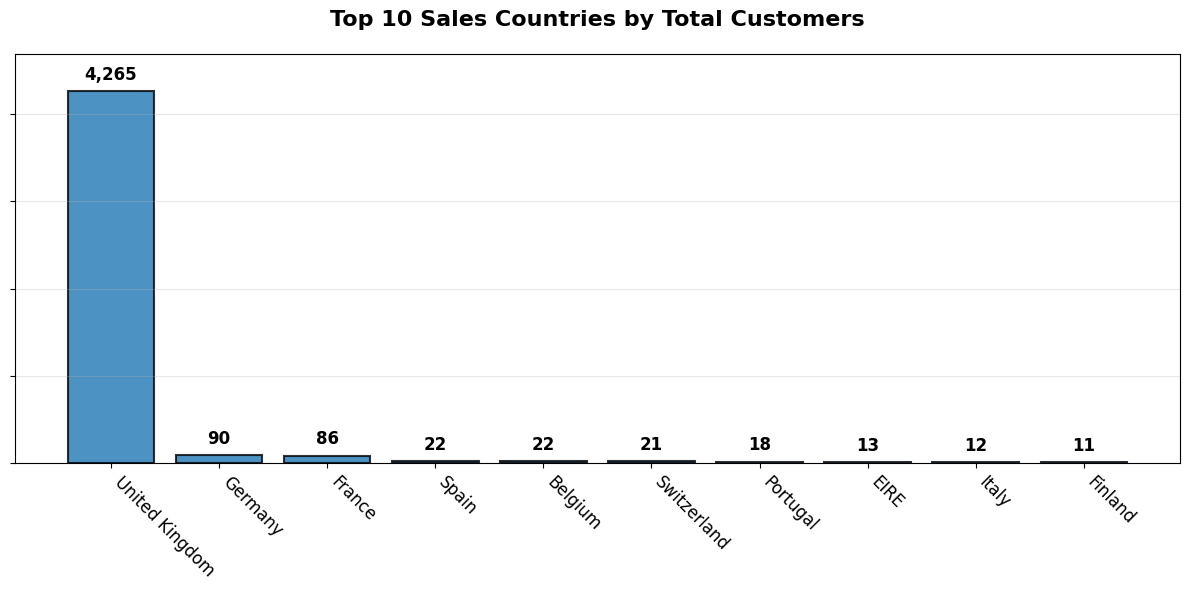

In [49]:
#Remove cancelled transactions
sales = sales[~sales['TransactionNo'].str.contains(r'[A-Za-z]+', regex=True)]

#Convert CustomerNo to string
sales["CustomerNo"] = sales["CustomerNo"].astype("Int64", errors='ignore').astype(str, errors='ignore')  
#Country distribution
country_counts = (sales
                  .groupby(["Country"])
                  .agg({"CustomerNo":"nunique", "Price":"sum", "Quantity":'sum'})
                  .reset_index()
                  .sort_values('CustomerNo', ascending=False)
                  .rename(columns={'CustomerNo': 'Counts'})
                  .head(10)
)

# Create matplotlib bar chart
bars = plt.bar(range(len(country_counts)), country_counts['Counts'], 
               color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xticks(range(len(country_counts)), country_counts['Country'], 
           rotation=-45, ha='left', fontsize=12)
plt.ylabel('')
plt.title('Top 10 Sales Countries by Total Customers', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Remove y-axis tick labels but keep the grid
plt.gca().set_yticklabels([])
# Set y-axis limit with some padding
plt.ylim(0, country_counts['Counts'].max() * 1.1)

# Add value labels on top of bars
for i, v in enumerate(country_counts['Counts']):
    plt.text(i, v + country_counts['Counts'].max() * 0.02, f'{v:,}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Set background colors
plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.tight_layout()
plt.show()

### Continues features

In [50]:
print(f"There aren't non-positive values in Price and Quantity\n"\
    "But, distributions are higly asymetricsl")
sales.describe().iloc[:,1:]

There aren't non-positive values in Price and Quantity
But, distributions are higly asymetricsl


,Price,Quantity
count,502753.000000,502753.000000
mean,12.934431,10.498774
min,5.130000,1.000000
25%,11.100000,1.000000
50%,11.980000,4.000000
75%,14.090000,11.000000
max,660.620000,74215.000000
std,8.002980,112.707799


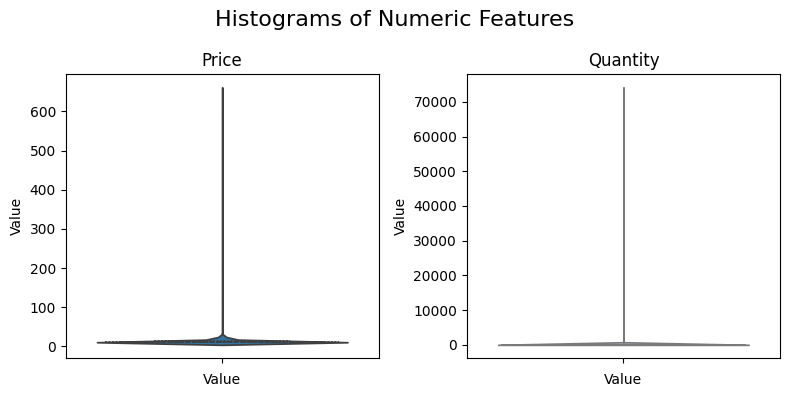

Seems that there are some Customers having Transactions with extremely large Quantities while most 75% is les than 11.
     These Customers are 12346, 13256
     The continues features in data seems to have extreme values
     Remove any non-positive value


In [51]:
#Check distributions of the continues features
check_numeric_cols(sales, 1, 2)
print(f"Seems that there are some Customers having Transactions with extremely large Quantities while most 75% is les than 11.\n\
     These Customers are {", ".join(list(sales[sales['Quantity'] > 5000].groupby('CustomerNo').count().reset_index().iloc[:,0]))}\n\
     The continues features in data seems to have extreme values\n\
     Remove any non-positive value")

In [52]:
sales[sales['CustomerNo'].isin(list(sales[sales['Quantity'] > 5000].groupby('CustomerNo').count().reset_index().iloc[:,0]))]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
473985,541431,2019-01-18,23166,Medium Ceramic Top Storage Jar,11.32,74215,12346,United Kingdom
41367,578841,2019-11-25,84826,Asstd Design 3d Paper Stickers,6.19,12540,13256,United Kingdom


In [53]:
print(f"Number of non-positive Price or Quantities: {len(sales[(sales["Price"] <= 0) | (sales["Quantity"] <= 0)])}")

Number of non-positive Price or Quantities: 0


### Missing values

In [54]:
sales.isna().sum().sum()

np.int64(0)

In [55]:
# drop rows with missing CustomerNo values
sales.dropna(subset = 'CustomerNo', inplace = True)
sales = sales[~(sales['CustomerNo'] == "<NA>")]

# Remove duplicates
print(f'Duplicates: {round(sales.duplicated().sum()/len(sales)*100,2)}%')
sales.drop_duplicates(inplace=True)

Duplicates: 0.99%


### Feature engineering

In [56]:
#Removed rows due to cleaning
final_rows = len(sales)
print(f"Inital Dataset consisted of {initial_rows} rows\n"\
      f"Final dataset: consisted of {final_rows:,} rows\n"\
      f"Data cleaning reduced inital data set by ~{round(((initial_rows - final_rows) / initial_rows) * 100, 1)}%")

#Data overview
sales.head()

Inital Dataset consisted of 536350 rows
Final dataset: consisted of 497,785 rows
Data cleaning reduced inital data set by ~7.2%


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
534296,536523,2018-12-01,22969,Homemade Jam Scented Candles,11.74,12,12868,United Kingdom
534295,536523,2018-12-01,21259,Victorian Sewing Box Small,16.35,2,12868,United Kingdom
534294,536523,2018-12-01,21485,Retrospot Heart Hot Water Bottle,15.32,3,12868,United Kingdom
534293,536523,2018-12-01,22149,Feltcraft 6 Flower Friends,12.40,6,12868,United Kingdom
534292,536523,2018-12-01,22468,Babushka Lights String Of 10,17.17,2,12868,United Kingdom


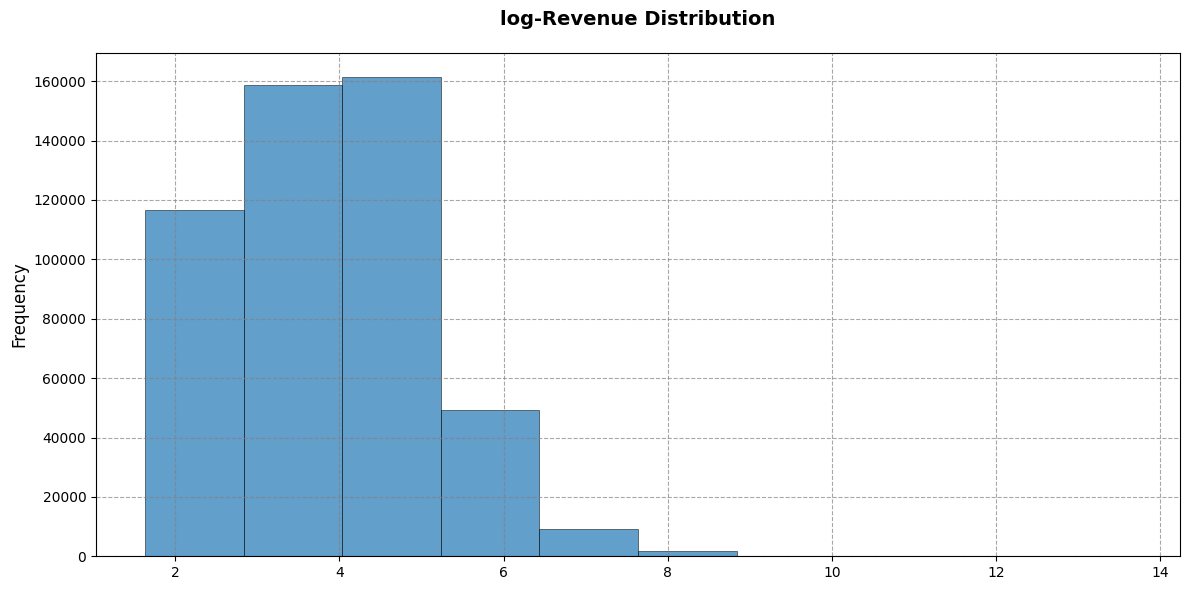

In [57]:
# Calculate revenue
sales['revenue'] = sales['Price'] * sales['Quantity']
sales['logrevenue'] = np.log(sales['revenue'])

# Create matplotlib box plot
plt.hist(sales['logrevenue'], color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.5)

plt.ylabel('Frequency', fontsize=12)
plt.title('log-Revenue Distribution', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, color='#878080', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.tight_layout()
plt.show()

In [58]:
# Extract date components
sales['month'] = sales['Date'].dt.month
sales['month_name'] = sales['Date'].dt.month_name()
sales['dow'] = sales['Date'].dt.day_of_week
sales['day_of_week'] = sales['Date'].dt.day_name()

# Top products by revenue
top_products_revenue = sales.groupby('ProductName')['revenue'].sum().nlargest(10).sort_values(ascending=True)
# Top countries by revenue
top_countries = sales.groupby('Country')['revenue'].sum().nlargest(5)
# Monthly revenue trend
monthly_revenue = sales.groupby('month')['revenue'].sum().reset_index()

# Apply categorization
sales['Category'] = sales['ProductName'].apply(categorize_product)

# Check category distribution
print("Product Categories :")
print(sales['Category'].value_counts().head(10))

print("\nFinal cleaned dataset:")
sales.head()

Product Categories :
Category
Kitchen & Dining       121552
Home Decor             105660
Other                  104968
Bags & Accessories      51500
Stationery & Office     25366
Food & Consumables      13992
Christmas & Holiday     12430
Garden & Outdoor        12264
Clothing & Textiles      8873
Travel Accessories       7610
Name: count, dtype: int64

Final cleaned dataset:


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,revenue,logrevenue,month,month_name,dow,day_of_week,Category
534296,536523,2018-12-01,22969,Homemade Jam Scented Candles,11.74,12,12868,United Kingdom,140.88,4.947908,12,December,5,Saturday,Home Decor
534295,536523,2018-12-01,21259,Victorian Sewing Box Small,16.35,2,12868,United Kingdom,32.70,3.487375,12,December,5,Saturday,Clothing & Textiles
534294,536523,2018-12-01,21485,Retrospot Heart Hot Water Bottle,15.32,3,12868,United Kingdom,45.96,3.827771,12,December,5,Saturday,Kitchen & Dining
534293,536523,2018-12-01,22149,Feltcraft 6 Flower Friends,12.40,6,12868,United Kingdom,74.40,4.309456,12,December,5,Saturday,Garden & Outdoor
534292,536523,2018-12-01,22468,Babushka Lights String Of 10,17.17,2,12868,United Kingdom,34.34,3.536311,12,December,5,Saturday,Home Decor


## 4. Exploratory Data Analysis (EDA)


### Bulk vs Retail Customers

In [59]:
# calculate total quantity per transaction
grouped = sales.groupby(['CustomerNo', 'TransactionNo'])['Quantity'].sum().reset_index()

# compute the avg quantity per transaction 
avg_per_customer = grouped.groupby('CustomerNo')['Quantity'].mean().reset_index(name='AvgQuantity')

# segment customers based on average quantity per transaction
small_orders = avg_per_customer[avg_per_customer['AvgQuantity'] <=100]
big_orders = avg_per_customer[avg_per_customer['AvgQuantity'] > 100]
# create sets of customers id for each segment
set1 = set(small_orders['CustomerNo'])
set2 = set(big_orders['CustomerNo'])

#average quantity per transaction 
avg_quantity_per_transaction = sales['Quantity'].sum()/sales['TransactionNo'].nunique()
print(f"Average quantity per transaction: {avg_quantity_per_transaction}")

# display counts of each customer type and check overlap 
print(f"Retail Customers (AVG Quantity Per Transaction <= 100)\n{len(set1)}")
print(f"Bulk Customers (AVG Quantity Per Transaction > 100)\n{len(set2)}")

# label each transaction row with its customer segment
sales['customer_segment'] = sales['CustomerNo'].apply(lambda x: 'Retail' if x in list(set1) else 'Bulk')

Average quantity per transaction: 277.3608475648324
Retail Customers (AVG Quantity Per Transaction <= 100)
1373
Bulk Customers (AVG Quantity Per Transaction > 100)
3298


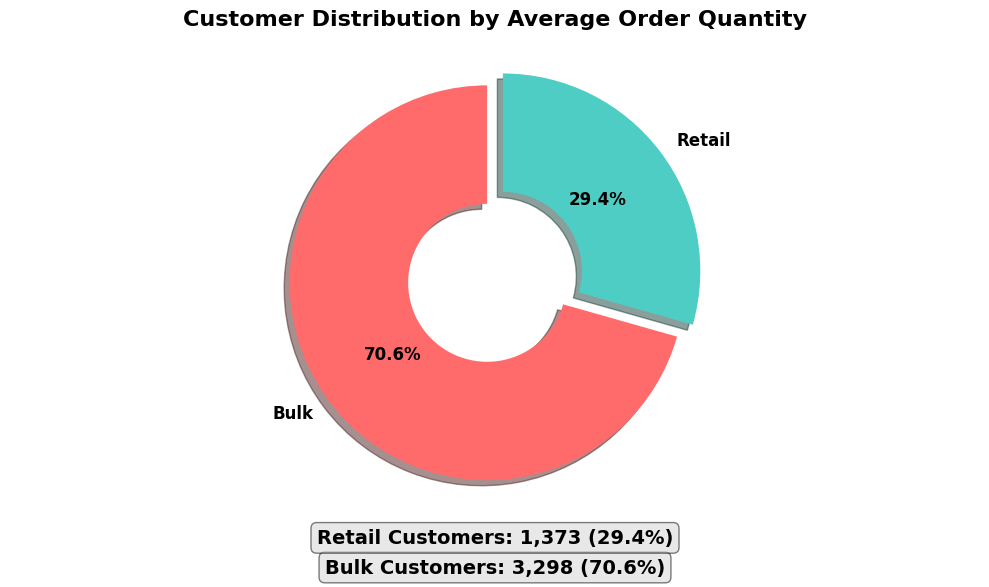

In [60]:
# Create pie plot of customer segments
customer_segment_counts = sales['CustomerNo'].drop_duplicates().map(
    lambda x: 'Retail' if x in set1 else 'Bulk'
).value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

# Create the donut chart
wedges, texts, autotexts = ax.pie(customer_segment_counts.values,
                                  labels=customer_segment_counts.index,
                                  autopct='%1.1f%%',
                                  colors=['#FF6B6B', '#4ECDC4'],
                                  explode=(0.05, 0.05),
                                  shadow=True,
                                  startangle=90,
                                  textprops={'fontsize': 12, 'fontweight': 'bold'},
                                  wedgeprops=dict(width=0.6))  # This creates the donut effect

# Add a circle at the center to make it look more like a donut
centre_circle = plt.Circle((0,0), 0.40, fc='white', linewidth=2, edgecolor='black')

plt.title('Customer Distribution by Average Order Quantity', 
          fontsize=16, fontweight='bold', pad=20)

# Add detailed count information below
for i, (label, count) in enumerate(zip(customer_segment_counts.index, customer_segment_counts.values)):
    percentage = count / customer_segment_counts.sum() * 100
    plt.text(0, -1.5 + i*0.15, f'{label} Customers: {count:,} ({percentage:.1f}%)', 
             ha='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))

plt.axis('equal')
plt.tight_layout()
plt.show()

### Key metrics

In [61]:
# Key metrics calculations
date_range = f"{sales['Date'].min().strftime('%Y-%m-%d')} to {sales['Date'].max().strftime('%Y-%m-%d')}"

# UK market analysis
uk_revenue = sales[sales['Country'] == 'United Kingdom']['revenue'].sum()
uk_percentage = (uk_revenue / sales['revenue'].sum()) * 100

# Seasonal and temporal insights
seasonal = sales.groupby('month')['revenue'].sum()
dow_revenue = sales.groupby('day_of_week')['revenue'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

peak_month = seasonal.idxmax()
peak_day = dow_revenue.idxmax()

print(f" Total Revenue: £{sales['revenue'].sum():,.2f}")
print(f" Total Customers: {sales['CustomerNo'].nunique():,}")
print(f" Product Catalog: {sales['ProductNo'].nunique():,}")
print(f" Average Order Value: £{sales['revenue'].mean():.2f}")
print(f" Average Quantity per Transaction: {avg_quantity_per_transaction:.2f}")
print(f" Date Range: {date_range}")
print(f" UK Market Share: {uk_percentage:.1f}%")
print(f" Peak Month: {peak_month}")
print(f" Best Day: {peak_day}")

 Total Revenue: £60,269,235.02
 Total Customers: 4,671
 Product Catalog: 3,751
 Average Order Value: £121.07
 Average Quantity per Transaction: 277.36
 Date Range: 2018-12-01 to 2019-11-30
 UK Market Share: 83.0%
 Peak Month: 11
 Best Day: Sunday


### Top Products by Revenue


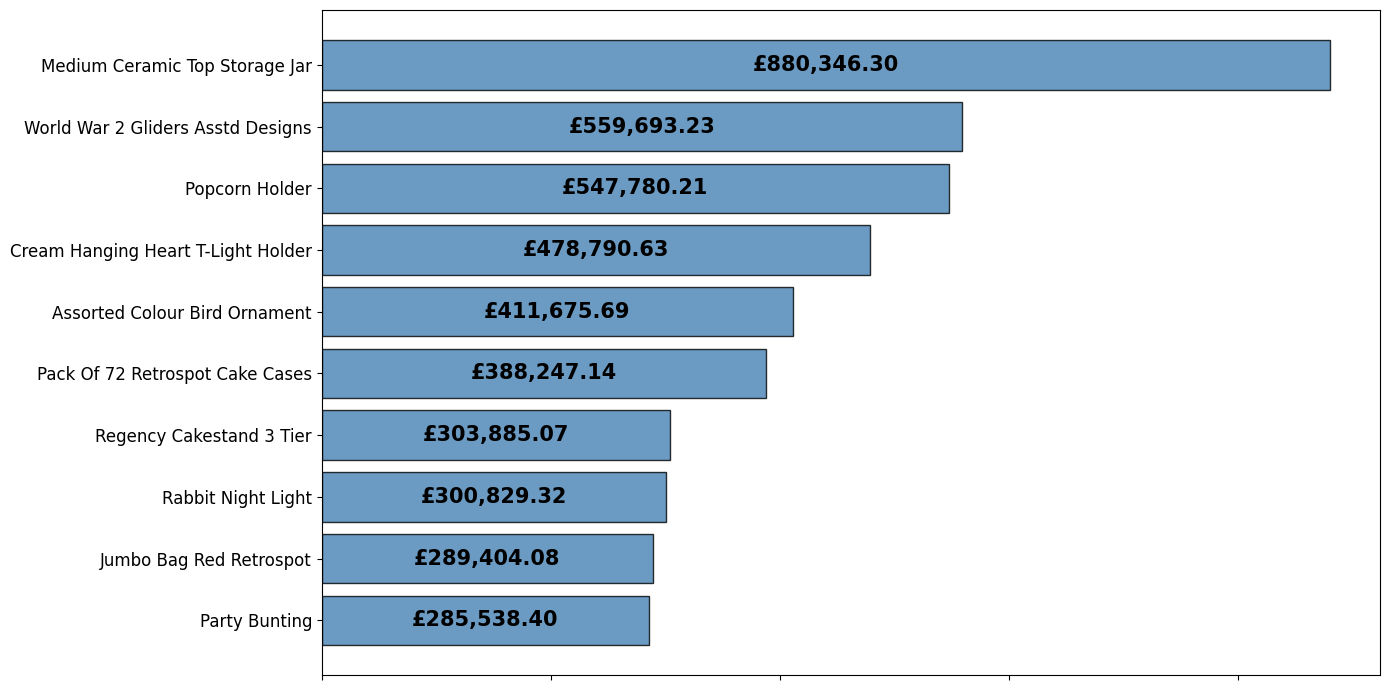

In [62]:
plt.figure(figsize=(14, 7))

bars = plt.barh(range(len(top_products_revenue)), top_products_revenue.values, 
                color='steelblue', alpha=0.8, edgecolor='black')

plt.yticks(range(len(top_products_revenue)), 
           [name[:40] + '...' if len(name) > 40 else name for name in top_products_revenue.index])
plt.xlabel('')
#plt.title('Top 10 Products by Revenue (£)', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0)

plt.gca().set_xticklabels([]) 
plt.yticks(rotation=0, fontsize=12) 

# Add value labels on bars
for i, v in enumerate(top_products_revenue.values):
    plt.text(v / 2, i, f'£{v:,.2f}', 
             va='center', ha='center', fontsize=15, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

### Monthly & Week-Day Revenue 

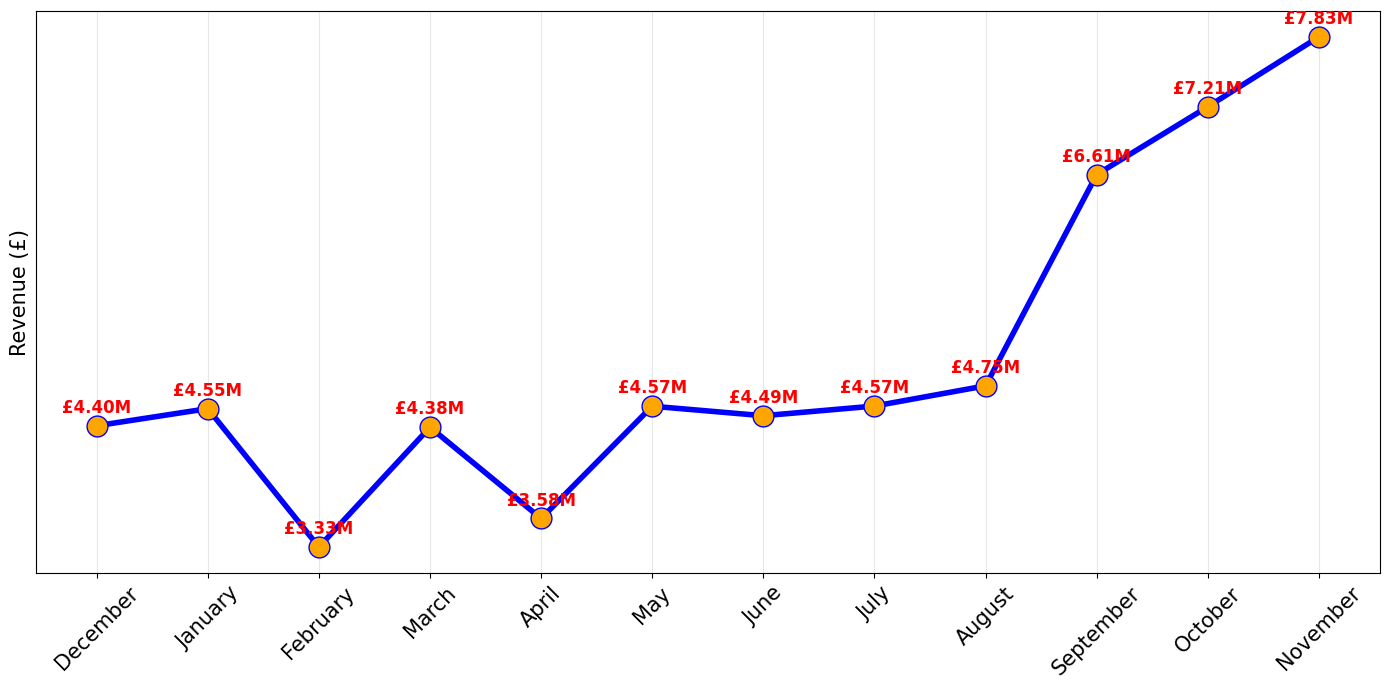

In [63]:
# Prepare monthly revenue with month names and sort by month number, December first
monthly_revenue_sorted = monthly_revenue.copy()
monthly_revenue_sorted['month_num'] = monthly_revenue_sorted['month']
monthly_revenue_sorted['month_name'] = monthly_revenue_sorted['month_num'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

# Move December to the top
december = monthly_revenue_sorted[monthly_revenue_sorted['month_num'] == 12]
other_months = monthly_revenue_sorted[monthly_revenue_sorted['month_num'] != 12]
monthly_revenue_sorted = pd.concat([december, other_months]).reset_index(drop=True)

plt.figure(figsize=(14, 7))

plt.plot(monthly_revenue_sorted['month_name'], monthly_revenue_sorted['revenue'], 
         marker='o', linewidth=4, markersize=15, color='blue', markerfacecolor='orange')

plt.xlabel('')
plt.ylabel('Revenue (£)', fontsize=15)
#plt.title('Monthly Revenue Trend (£)', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=15)  

# Remove y-axis values
plt.gca().set_yticks([])

# Add value labels on points in red with 2 decimals
for i, row in monthly_revenue_sorted.iterrows():
    plt.annotate(f'£{row["revenue"]/1e6:.2f}M', 
                 (row['month_name'], row['revenue']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

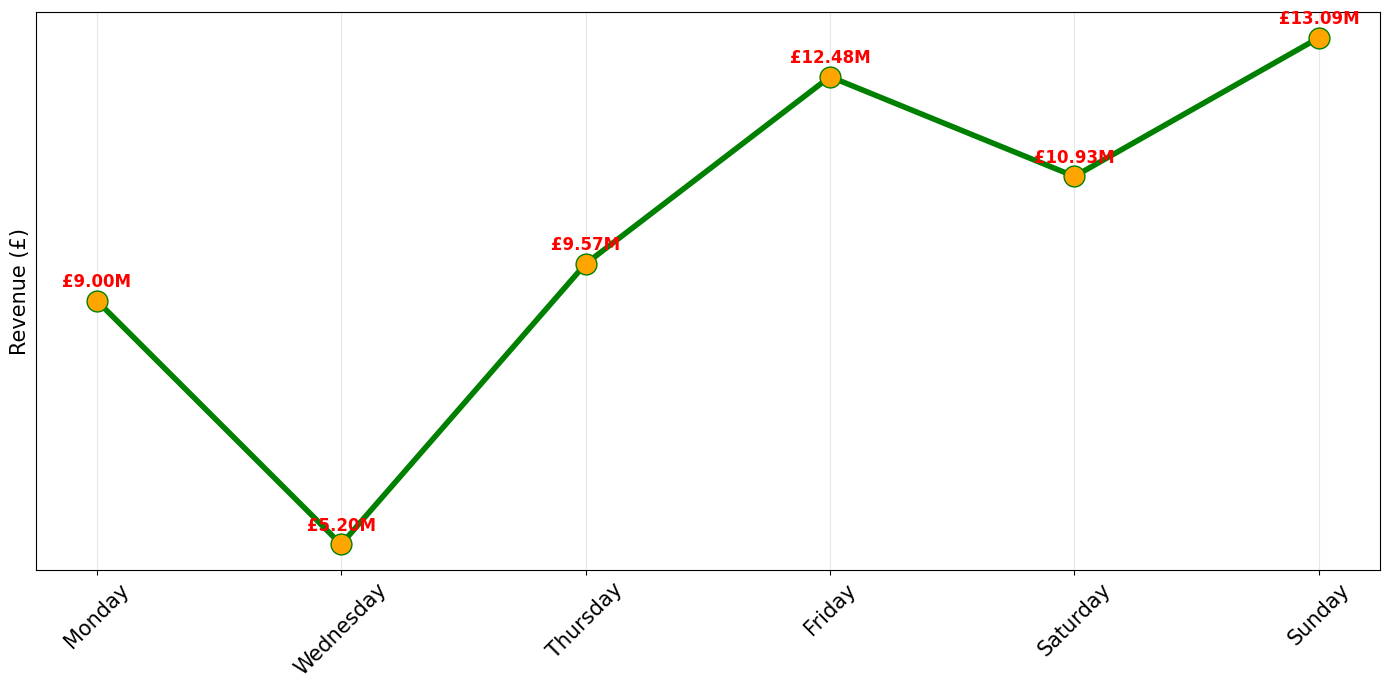

In [64]:
# Prepare daily revenue by day of week
daily_revenue = sales.groupby('day_of_week')['revenue'].sum().reset_index()

# Reorder days of week starting with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_revenue['day_order'] = daily_revenue['day_of_week'].apply(lambda x: day_order.index(x))
daily_revenue_sorted = daily_revenue.sort_values('day_order').reset_index(drop=True)

plt.figure(figsize=(14, 7))

plt.plot(daily_revenue_sorted['day_of_week'], daily_revenue_sorted['revenue'], 
         marker='o', linewidth=4, markersize=15, color='green', markerfacecolor='orange')

plt.xlabel('')
plt.ylabel('Revenue (£)', fontsize=15)
#plt.title('Daily Revenue Trend by Day of Week (£)', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=15)  

# Remove y-axis values
plt.gca().set_yticks([])

# Add value labels on points in red with 2 decimals
for i, row in daily_revenue_sorted.iterrows():
    plt.annotate(f'£{row["revenue"]/1e6:.2f}M', 
                 (row['day_of_week'], row['revenue']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

### Top Countries by Revenue

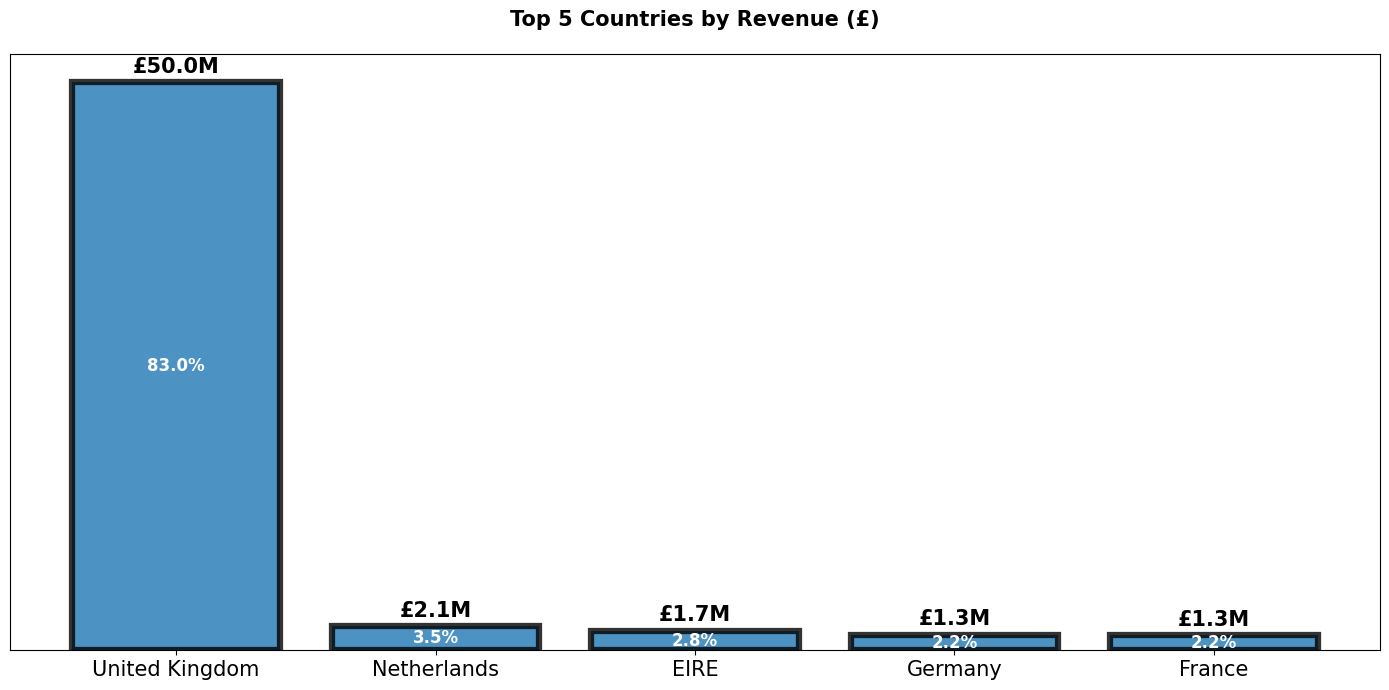

In [65]:
plt.figure(figsize=(14, 7))

bars = plt.bar(range(len(top_countries)), top_countries.values, 
               color=['#1f77b4'], 
               alpha=0.8, edgecolor='black', linewidth=4.5)

plt.xticks(range(len(top_countries)), top_countries.index, fontsize=15)
plt.ylabel('')
plt.title('Top 5 Countries by Revenue (£)', fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Remove y-axis values but keep y-axis title
plt.gca().set_yticks([])

# Add value labels on bars
for i, v in enumerate(top_countries.values):
    plt.text(i, v + max(top_countries.values) * 0.01, f'£{v/1e6:.1f}M', 
             ha='center', va='bottom', fontsize=15, fontweight='bold')

# Add percentage labels
total_revenue = top_countries.sum()
for i, v in enumerate(top_countries.values):
    pct = (v / sales['revenue'].sum()) * 100
    plt.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=12, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

### Top categories

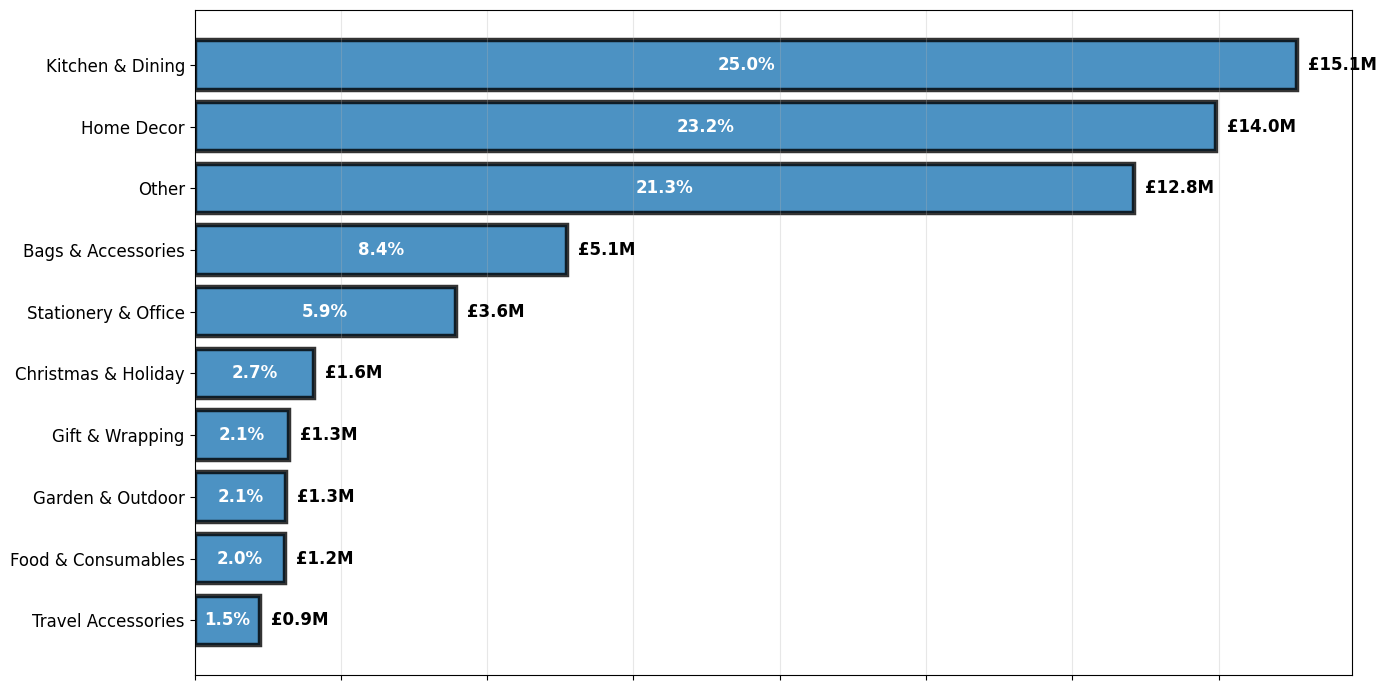

In [66]:
category_metrics = sales.groupby('Category').agg({
    'revenue': ['sum', 'mean', 'count'],
    'Quantity': 'sum',
    'CustomerNo': 'nunique',
    'ProductNo': 'nunique'
}).round(2)

category_metrics.columns = ['total_revenue', 'avg_revenue', 'transaction_count', 
                           'total_quantity', 'unique_customers', 'unique_products']
category_metrics['revenue_percentage'] = (category_metrics['total_revenue'] / 
                                        category_metrics['total_revenue'].sum() * 100).round(1)
category_metrics = category_metrics.sort_values('total_revenue', ascending=False)

# Take top 10 categories only
top10_categories = category_metrics.head(10)

# Category Revenue Distribution (Top 10)
plt.figure(figsize=(14, 7))
revenue_data = top10_categories.sort_values('total_revenue', ascending=True)

bars = plt.barh(range(len(revenue_data)), revenue_data['total_revenue'], 
                color=['#1f77b4'], alpha=0.8, edgecolor='black', linewidth=3.2)

plt.yticks(range(len(revenue_data)), revenue_data.index, fontsize=12)
plt.xlabel('')
#plt.title('Top 10 Product Categories by Revenue (£)', fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

for i, v in enumerate(revenue_data['total_revenue']):
    plt.text(v + max(revenue_data['total_revenue']) * 0.01, i, f'£{v/1e6:.1f}M', 
             va='center', fontsize=12, fontweight='bold')

for i, (idx, row) in enumerate(revenue_data.iterrows()):
    pct = row['revenue_percentage']
    plt.text(row['total_revenue']/2, i, f'{pct}%', 
             ha='center', va='center', fontsize=12, fontweight='bold', color='white')

plt.gca().set_xticklabels([])
 
plt.tight_layout()
plt.show()

##  6. RFM Analysis (Customer Segmentation)


In [67]:
# RFM Analysis
current_date = sales['Date'].max()

rfm = sales.groupby('CustomerNo').agg({
    'Date': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionNo': 'count',                          # Frequency  
    'revenue': 'sum'                                   # Monetary
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create RFM scores (1-5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerNo,,,,,,
12004,218,56,1509.60,1,3,2
12006,209,1,24.76,1,1,1
12008,267,203,5689.57,1,5,3
12013,350,1,69.96,1,1,1
12024,167,5,149.52,2,1,1


In [68]:
rfm.Frequency.max()

np.int64(7207)

In [69]:
rfm['Segment'] = rfm.apply(segment_customers, axis=1)


print("Customer Segment Distribution:")
print(rfm['Segment'].value_counts())


Customer Segment Distribution:
Segment
VIP                          940
Need Activation              891
Others                       802
At Risk                      569
Loyal Customers              521
Potential Loyal Customers    519
New Customers                241
Hibernating                  188
Name: count, dtype: int64


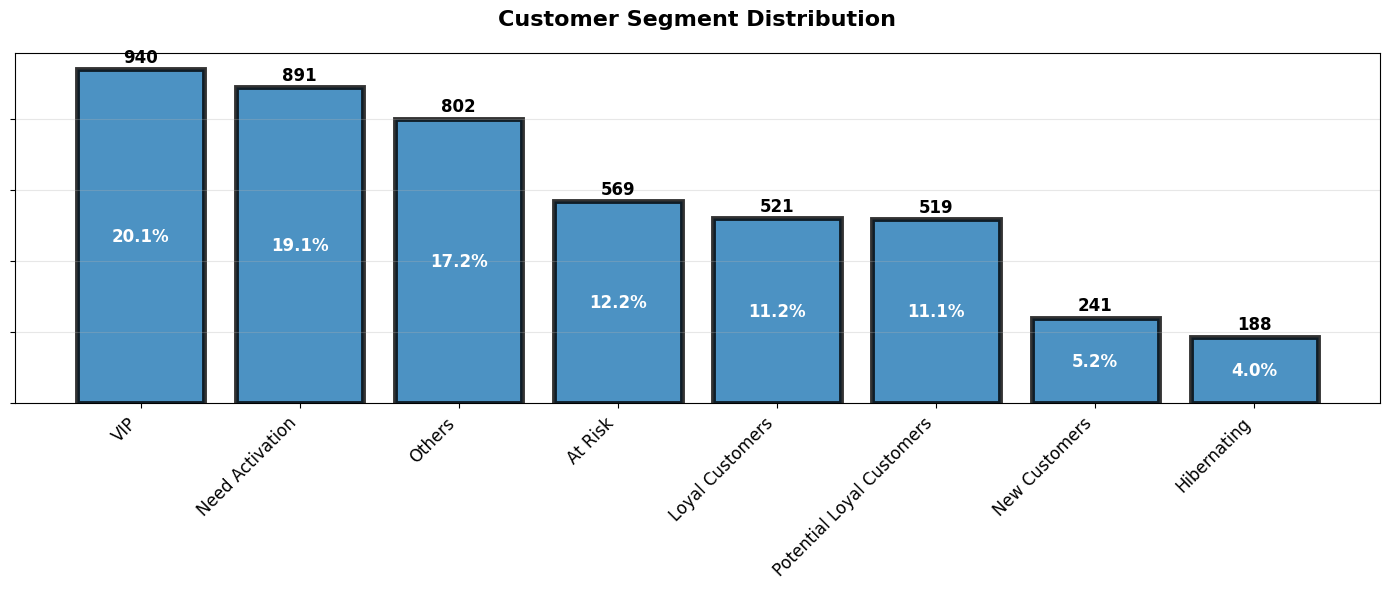

In [70]:
# Customer Segment Distribution
plt.figure(figsize=(14, 6))
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)

# Create bar chart
bars = plt.bar(range(len(segment_counts)), segment_counts.values, 
               color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=3.5)

plt.xticks(range(len(segment_counts)), segment_counts.index, fontsize=12, rotation=45, ha='right')
plt.ylabel('')
plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(segment_counts.values):
    plt.text(i, v + max(segment_counts.values) * 0.01, f'{v:,}', 
             ha='center', va='bottom', fontsize=12, fontweight='black')

# Add percentage labels inside bars
total_customers = segment_counts.sum()
for i, v in enumerate(segment_counts.values):
    pct = (v / total_customers) * 100
    plt.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=12, fontweight='bold', color='white')

plt.gca().set_yticklabels([])

plt.tight_layout()
plt.show()

### Pareto Priciple

In [71]:
#Pareto Analysis 
pareto_df = rfm[['Monetary']].sort_values(by='Monetary', ascending=False).copy()
pareto_df['Cumulative_Revenue'] = pareto_df['Monetary'].cumsum()
pareto_df['Cumulative_Percent_Revenue'] = 100 * pareto_df['Cumulative_Revenue'] / pareto_df['Monetary'].sum()
pareto_df['Cumulative_Percent_Customers'] = 100 * (pareto_df.reset_index().index + 1) / len(pareto_df)

#Identify 80% revenue contributors
top_20_cutoff = pareto_df[pareto_df['Cumulative_Percent_Revenue'] <= 80]
num_top_customers = len(top_20_cutoff)
percentage_top_customers = 100 * num_top_customers / len(pareto_df)

print(f"{percentage_top_customers:.1f}% of customers generate 80% of total revenue.")

28.0% of customers generate 80% of total revenue.


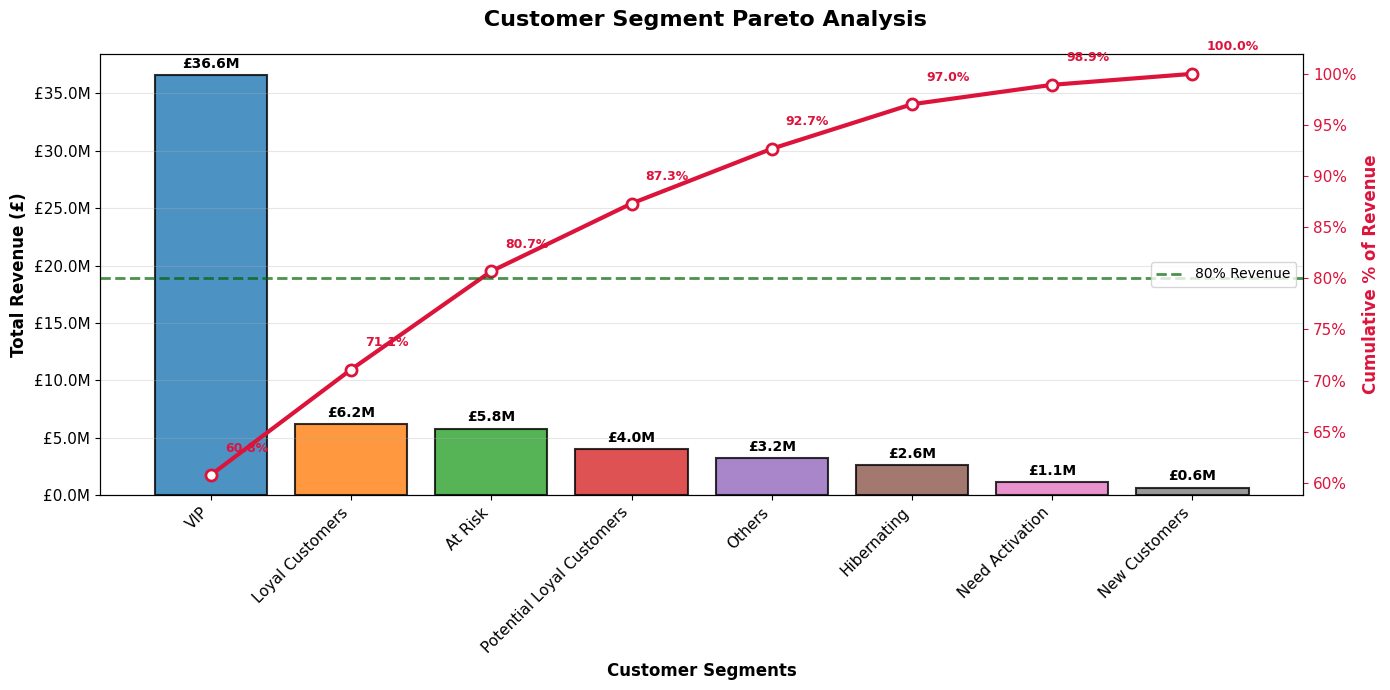

PARETO ANALYSIS INSIGHTS
Top 3 segments generate: £48.6M (80.7% of total revenue)
80% revenue threshold reached at: At Risk segment


In [72]:
# Customer Segment Pareto Analysis 
plt.figure(figsize=(14, 7))

# Prepare data
segments_pareto = (
    rfm.groupby('Segment')['Monetary']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'Segment': 'Segment_labels', 'Monetary': 'TotalMonetary'})
)

# Compute cumulative percentage of revenue
segments_pareto['CumulativeMonetary'] = segments_pareto['TotalMonetary'].cumsum()
segments_pareto['CumulativePercentage'] = 100 * segments_pareto['CumulativeMonetary'] / segments_pareto['TotalMonetary'].sum()

# Create the main axis for bars
ax1 = plt.gca()

# Create bars with consistent styling
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
bars = ax1.bar(range(len(segments_pareto)), segments_pareto['TotalMonetary'], 
               color=colors[:len(segments_pareto)], alpha=0.8, edgecolor='black', linewidth=1.5)

# Create secondary axis for cumulative percentage line
ax2 = ax1.twinx()
line = ax2.plot(range(len(segments_pareto)), segments_pareto['CumulativePercentage'],
                color='crimson', marker='o', markersize=8, linewidth=3, 
                markerfacecolor='white', markeredgecolor='crimson', markeredgewidth=2)

# Add 80% reference line
ax2.axhline(80, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7, label='80% Revenue')

# Styling consistent with other plots
ax1.set_xlabel('Customer Segments', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Revenue (£)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative % of Revenue', fontsize=12, fontweight='bold', color='crimson')

# Format axes
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

# Set x-ticks
ax1.set_xticks(range(len(segments_pareto)))
ax1.set_xticklabels(segments_pareto['Segment_labels'], fontsize=11, rotation=45, ha='right')

# Title and grid
plt.title(' Customer Segment Pareto Analysis', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(segments_pareto['TotalMonetary']):
    ax1.text(i, v + max(segments_pareto['TotalMonetary']) * 0.01, f'£{v/1e6:.1f}M', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add cumulative percentage labels on line
for i, (revenue, cum_pct, segment) in enumerate(zip(segments_pareto['TotalMonetary'], 
                                                    segments_pareto['CumulativePercentage'],
                                                    segments_pareto['Segment_labels'])):
    # Cumulative percentage on line
    ax2.text(i + 0.1, cum_pct + 2, f'{cum_pct:.1f}%', ha='left', va='bottom', 
             fontsize=9, fontweight='bold', color='crimson')

# Add legend for the reference line
ax2.legend(loc='center right', fontsize=10)

# Color the y-axis labels to match their data
ax2.tick_params(axis='y', colors='crimson', labelsize=11)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)

plt.tight_layout()
plt.show()

# Print insights
print("PARETO ANALYSIS INSIGHTS")
top_3_segments = segments_pareto.head(3)
top_3_revenue = top_3_segments['TotalMonetary'].sum()
total_revenue = segments_pareto['TotalMonetary'].sum()
top_3_percentage = (top_3_revenue / total_revenue) * 100

print(f"Top 3 segments generate: £{top_3_revenue/1e6:.1f}M ({top_3_percentage:.1f}% of total revenue)")
print(f"80% revenue threshold reached at: {segments_pareto[segments_pareto['CumulativePercentage'] >= 80].iloc[0]['Segment_labels']} segment")


##  7. Cohort Analysis (Customer Retention)


In [73]:
# Prepare data for cohort analysis
cohort = sales[['CustomerNo','Date','ProductName']].copy()

print("Date Range for Cohort Analysis:")
print(f"From: {cohort['Date'].min()}")
print(f"To: {cohort['Date'].max()}")

# Create period columns
cohort['order_month'] = cohort['Date'].dt.to_period('M')

# Create cohort data
df_cohort = cohort.copy()
df_cohort['cohort'] = df_cohort.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')
df_cohort = df_cohort.groupby(['cohort','order_month']).agg(n_customers=('CustomerNo','nunique')).reset_index()
df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(attrgetter('n'))

df_cohort.head()


Date Range for Cohort Analysis:
From: 2018-12-01 00:00:00
To: 2019-11-30 00:00:00


,cohort,order_month,n_customers,period_number
0,2018-12,2018-12,1026,0
1,2018-12,2019-01,341,1
2,2018-12,2019-02,310,2
3,2018-12,2019-03,368,3
4,2018-12,2019-04,355,4


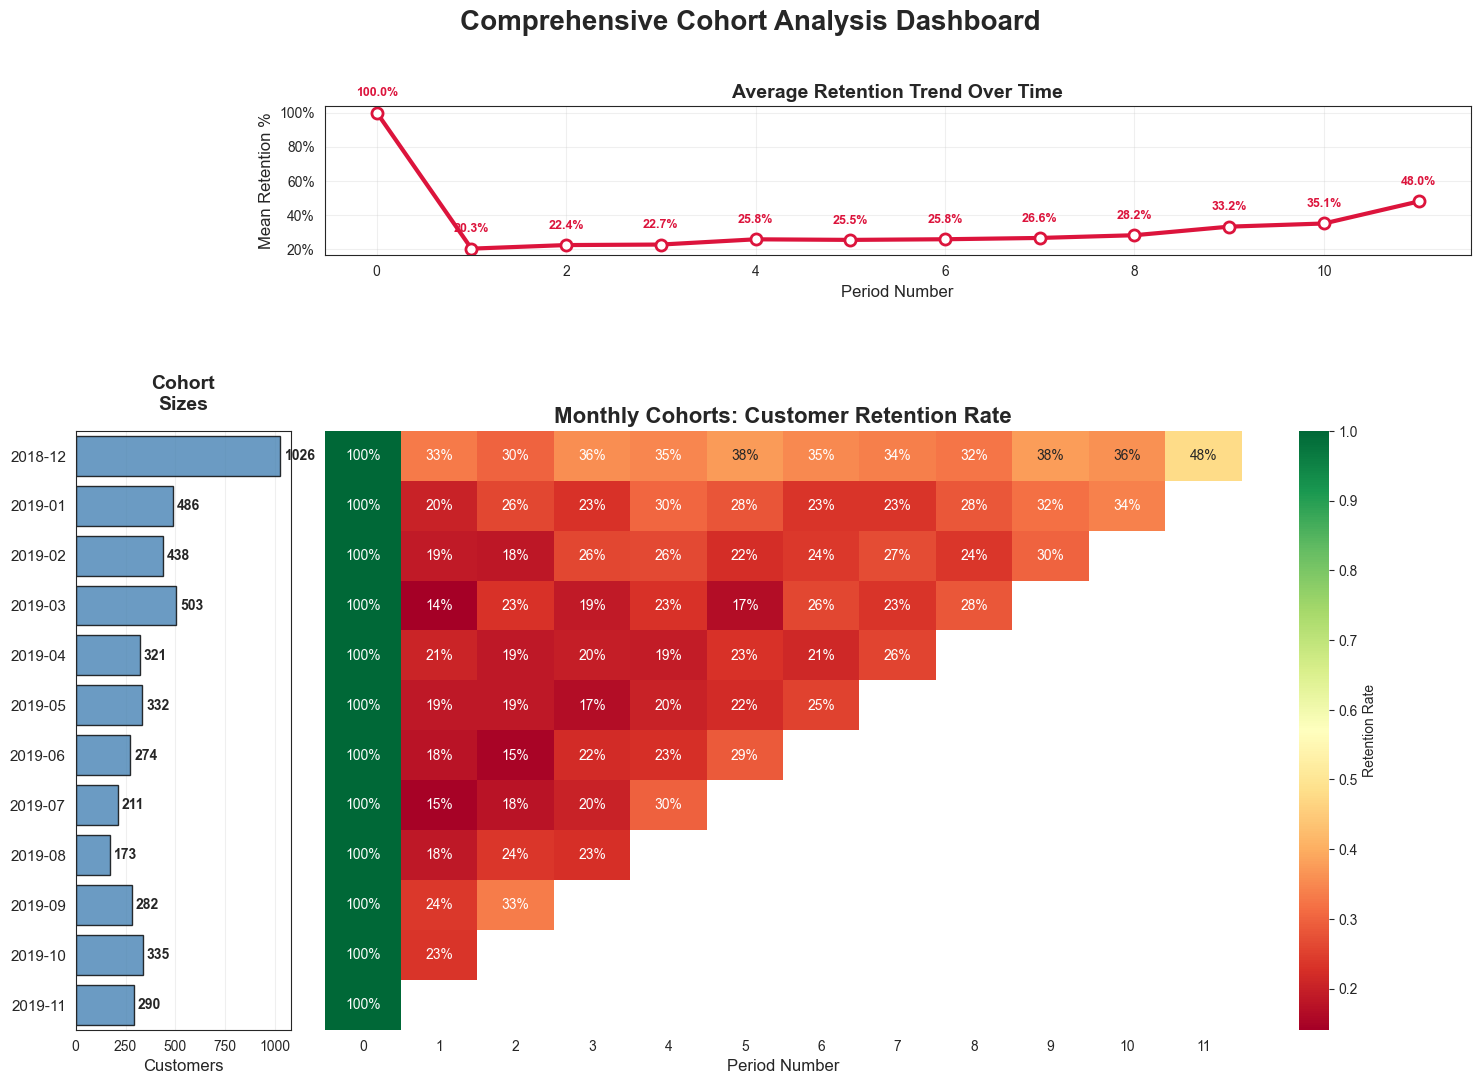

In [74]:
# Create cohort pivot table and retention matrix
cohort_pivot = df_cohort.pivot_table(index='cohort', 
                                     columns='period_number', 
                                     values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0].astype(int)  # Convert to int to avoid float display
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Enhanced Cohort Analysis Visualization with Dashboard Layout
with sns.axes_style("white"):
    # Create a figure with custom gridspec for multiple subplots
    fig = plt.figure(figsize=(18, 12))  # Slightly larger for better proportions
    gs = fig.add_gridspec(3, 2, height_ratios=[0.7, 0.1, 2.8], width_ratios=[1.5, 8], 
                         hspace=0.3, wspace=0.05)  # Adjusted width ratios and spacing
    
    # 1. Cohort sizes bar plot (left side) - REVERSED
    ax_bar = fig.add_subplot(gs[2, 0])
    cohort_labels = [str(c) for c in cohort_size.index]
    # Reverse the order for the bar plot
    bars = ax_bar.barh(range(len(cohort_size)), cohort_size.values[::-1], 
                       color='steelblue', alpha=0.8, edgecolor='black')
    ax_bar.set_yticks(range(len(cohort_size)))
    ax_bar.set_yticklabels(cohort_labels[::-1], fontsize=11)  # Reverse labels too
    ax_bar.set_title('Cohort\nSizes', fontsize=14, fontweight='bold', pad=15)
    ax_bar.set_xlabel('Customers', fontsize=12)
    ax_bar.grid(axis='x', alpha=0.3)
    
    # Set y-axis limits to match heatmap better
    ax_bar.set_ylim(-0.5, len(cohort_size) - 0.5)
    
    # Add value labels on bars (reversed values) - format as int
    for i, v in enumerate(cohort_size.values[::-1]):
        ax_bar.text(v + max(cohort_size.values) * 0.02, i, f'{int(v)}', 
                   va='center', fontsize=10, fontweight='bold')
    
    # 2. Mean retention trend line plot (top right)
    ax_trend = fig.add_subplot(gs[0, 1])
    
    # Calculate mean retention by period
    #    mean_retention_by_period = retention_matrix.iloc[1:(len(retention_matrix)-1),:].mean(axis=0).dropna()
    mean_retention_by_period = retention_matrix.mean(axis=0).dropna()
    periods = mean_retention_by_period.index
    
    ax_trend.plot(periods, mean_retention_by_period.values, 
                  marker='o', linewidth=3, markersize=8, color='crimson',
                  markerfacecolor='white', markeredgecolor='crimson', markeredgewidth=2)
    ax_trend.set_xlabel('Period Number', fontsize=12)
    ax_trend.set_ylabel('Mean Retention %', fontsize=12)
    ax_trend.grid(True, alpha=0.3)
    ax_trend.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    ax_trend.set_title('Average Retention Trend Over Time', fontsize=14, fontweight='bold')
    
    # Add value labels on points
    for i, (period, retention) in enumerate(zip(periods, mean_retention_by_period.values)):
        ax_trend.annotate(f'{retention:.1%}', 
                         (period, retention), 
                         textcoords="offset points", xytext=(0,12), 
                         ha='center', fontsize=9, fontweight='bold', color='crimson')
    
    # 3. Retention matrix heatmap (bottom right)
    ax_heatmap = fig.add_subplot(gs[2, 1])
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax_heatmap,
                cbar_kws={'label': 'Retention Rate'},
                square=False)  # Allow rectangular cells for better fit
    ax_heatmap.set_title('Monthly Cohorts: Customer Retention Rate', fontsize=16, fontweight='bold')
    ax_heatmap.set_xlabel('Period Number', fontsize=12)
    ax_heatmap.set_ylabel('', fontsize=12)
    ax_heatmap.set_yticklabels([])  # Remove y-axis tick labels
    
    # Ensure heatmap y-axis matches bar plot alignment
    ax_heatmap.set_ylim(len(cohort_size), 0)  # Reverse y-axis to match bar plot order
    
    plt.suptitle('Comprehensive Cohort Analysis Dashboard', fontsize=20, fontweight='bold', y=0.96)
    plt.tight_layout()
    plt.show()

In [75]:
print("Retention Pattern Analysis")

# Calculate specific first-month retention rates
first_month_rates = retention_matrix.iloc[:, 1].dropna()
avg_first_month = first_month_rates.mean()

print("\nFirst Month Dropoff:")
print(f"   • Average first-month retention: {avg_first_month:.1%}")
print(f"   • Customer loss in first month: {1-avg_first_month:.1%}")

print("\nAnalysis (Excluding December 2018 becuase its the first month of the analysis):")
seasonal_analysis = []
for cohort, rate in retention_matrix.iloc[:, 1].dropna().items():
    if hasattr(cohort, 'month'):
        month = cohort.month
        if not (cohort.year == 2018 and month == 12):
            seasonal_analysis.append((month, rate, str(cohort)))

seasonal_df = pd.DataFrame(seasonal_analysis, columns=['Month', 'Retention', 'Cohort'])
seasonal_avg = seasonal_df.groupby('Month')['Retention'].mean().sort_values(ascending=False)
    
print("   Top 3 months for retention :")
for i, (month, rate) in enumerate(seasonal_avg.head(3).items()):
        print(f"   {i+1}. Month {month}: {rate:.1%}")
    
print("\n   Bottom 3 months for retention :")
for i, (month, rate) in enumerate(seasonal_avg.tail(3).items()):
    print(f"   {i+1}. Month {month}: {rate:.1%}")

Retention Pattern Analysis

First Month Dropoff:
   • Average first-month retention: 20.3%
   • Customer loss in first month: 79.7%

Analysis (Excluding December 2018 becuase its the first month of the analysis):
   Top 3 months for retention :
   1. Month 9: 24.1%
   2. Month 10: 23.3%
   3. Month 4: 20.6%

   Bottom 3 months for retention :
   1. Month 6: 17.5%
   2. Month 7: 14.7%
   3. Month 3: 14.1%


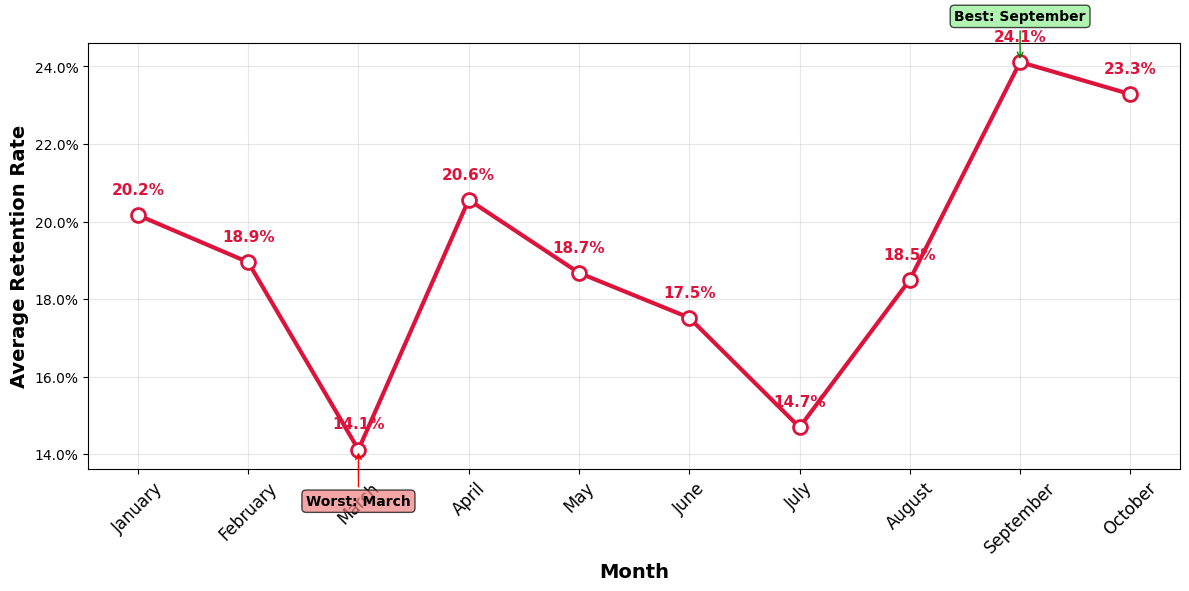

SEASONAL RETENTION INSIGHTS:
• Highest retention month: September (24.1%)
• Lowest retention month: March (14.1%)


In [76]:
# Create a mapping for month names and proper ordering
month_names = dict(zip(sales['month'].unique(),sales['month_name'].unique()))

# Convert seasonal_avg to DataFrame for easier manipulation
seasonal_plot_data = seasonal_avg.reset_index()
seasonal_plot_data['month_name'] = seasonal_plot_data['Month'].map(month_names)

# Sort by month number for proper chronological order
seasonal_plot_data = seasonal_plot_data.sort_values('Month')

# Create the line plot
plt.plot(seasonal_plot_data['month_name'], seasonal_plot_data['Retention'], 
         marker='o', linewidth=3, markersize=10, color='crimson',
         markerfacecolor='white', markeredgecolor='crimson', markeredgewidth=2)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Average Retention Rate', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

# Add value labels on points
for i, row in seasonal_plot_data.iterrows():
    plt.annotate(f'{row["Retention"]:.1%}', 
                 (row['month_name'], row['Retention']), 
                 textcoords="offset points", xytext=(0,15), 
                 ha='center', fontsize=11, fontweight='bold', color='crimson')

# Highlight best and worst performing months
best_month = seasonal_plot_data.loc[seasonal_plot_data['Retention'].idxmax()]
worst_month = seasonal_plot_data.loc[seasonal_plot_data['Retention'].idxmin()]

plt.annotate(f'Best: {best_month["month_name"]}', 
             xy=(best_month['month_name'], best_month['Retention']),
             xytext=(0, 30), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=10, fontweight='bold', ha='center')
plt.annotate(f'Worst: {worst_month["month_name"]}', 
             xy=(worst_month['month_name'], worst_month['Retention']),
             xytext=(0, -40), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, fontweight='bold', ha='center')
plt.tight_layout()
plt.show()

# Print insights
print("SEASONAL RETENTION INSIGHTS:")
print(f"• Highest retention month: {best_month['month_name']} ({best_month['Retention']:.1%})")
print(f"• Lowest retention month: {worst_month['month_name']} ({worst_month['Retention']:.1%})")

## 8. Market Basket Analysis

In [77]:

#market basket analysis df
mba_df = sales.copy()
cust_prod  = mba_df.groupby(['CustomerNo', 'Date'])['ProductName'].apply(list)
cust_prod_list = cust_prod.to_list()
#inputs
supp = 1
conf = 5
report = 'SacClL' # SacClL 
report_colnames = {
    'a': 'support_itemset_absolute',
    's': 'support_itemset_relative',
    'S': 'support_itemset_relative_pct',
    'b': 'support_bodyset_absolute',
    'x': 'support_bodyset_relative',
    'X': 'support_bodyset_relative_pct',
    'h': 'support_headitem_absolute',
    'y': 'support_headitem_relative',
    'Y': 'support_headitem_relative_pct',
    'c': 'confidence',
    'C': 'confidence_pct',
    'l': 'lift',
    'L': 'lift_pct',
    'e': 'evaluation',
    'E': 'evaluation_pct',
    'Q': 'support of the empty set (total number of transactions)'
    }
#apriori
apriori = arules(cust_prod_list,supp=supp,conf=conf,report=report,zmin= 2,zmax = 2, eval = 'x')
#Creat dataframe with columns based on the report variables and sorted based on the "Associations_Sorted_based_on"
colnames = ['Cons_Product', 'antecedent'] + [report_colnames.get(k, k) for k in list(report)]
df_rules = pd.DataFrame(apriori, columns=colnames)
df_rules = df_rules.sort_values(report_colnames["a"], ascending=False)
df_rules = df_rules[['antecedent', 'Cons_Product']+ [report_colnames.get(k, k) for k in list(report)]]

df_rules.head(5)

,antecedent,Cons_Product,support_itemset_relative_pct,support_itemset_absolute,confidence,confidence_pct,lift,lift_pct
1056,"(Jumbo Bag Pink Polkadot,)",Jumbo Bag Red Retrospot,4.691472,812,0.682353,68.235294,5.832180,583.218010
1057,"(Jumbo Bag Red Retrospot,)",Jumbo Bag Pink Polkadot,4.691472,812,0.400988,40.098765,5.832180,583.218010
405,"(Green Regency Teacup And Saucer,)",Roses Regency Teacup And Saucer,4.258147,737,0.752809,75.280899,12.711822,1271.182242
404,"(Roses Regency Teacup And Saucer,)",Green Regency Teacup And Saucer,4.258147,737,0.719024,71.902439,12.711822,1271.182242
182,"(Jumbo Storage Bag Suki,)",Jumbo Bag Red Retrospot,4.050150,701,0.612762,61.276224,5.237377,523.737719


In [78]:
#Total Transactions
print(f"Total Transactions: {sales['TransactionNo'].nunique()}")
#Average Items per Transaction
print(f"Average Items per Transaction: {sales.groupby('TransactionNo')['ProductName'].count().sum()/sales['TransactionNo'].nunique():.1f}")
#Max Items in Transaction
print(f"Max Items in Transaction: {sales.groupby('TransactionNo')['ProductName'].count().max()}")
#Transactions with multiple items
print(f'''Transactions with at least two items: {(sales.groupby('TransactionNo')['ProductName'].nunique() > 1).sum()
      } | {((sales.groupby('TransactionNo')['ProductName'].nunique() > 1).sum()/sales['TransactionNo'].nunique())*100:.1f}% of total transactions''')
print("\nTOP 10 PRODUCT ASSOCIATIONS (by Lift and Confidence):\n")
for i, row in df_rules.sort_values(by=['confidence','lift'], ascending=False).head(10).iterrows():
    print(f"{row['antecedent']} → {row['Cons_Product']} | Lift: {row['lift']:.2f} | Conf: {row['confidence']:.1%}")
print("\nTOP 10 PRODUCT ASSOCIATIONS (by Support):\n")
for i, row in df_rules.sort_values(by='support_itemset_absolute', ascending=False).head(10).iterrows():
    print(f"{row['antecedent']} → {row['Cons_Product']} | Support: {row['support_itemset_relative_pct']:.2f}% | Count: {row['support_itemset_absolute']:,}")

Total Transactions: 18972
Average Items per Transaction: 26.2
Max Items in Transaction: 1110
Transactions with at least two items: 17527 | 92.4% of total transactions

TOP 10 PRODUCT ASSOCIATIONS (by Lift and Confidence):

('Herb Marker Thyme',) → Herb Marker Rosemary | Lift: 71.19 | Conf: 93.4%
('Herb Marker Rosemary',) → Herb Marker Thyme | Lift: 71.19 | Conf: 93.0%
('Herb Marker Chives',) → Herb Marker Parsley | Lift: 71.07 | Conf: 92.4%
('Herb Marker Chives',) → Herb Marker Thyme | Lift: 69.98 | Conf: 91.4%
('Regency Tea Plate Pink',) → Regency Tea Plate Green | Lift: 43.85 | Conf: 91.2%
('Herb Marker Chives',) → Herb Marker Mint | Lift: 69.28 | Conf: 90.9%
('Herb Marker Chives',) → Herb Marker Rosemary | Lift: 69.28 | Conf: 90.9%
('Herb Marker Parsley',) → Herb Marker Thyme | Lift: 69.44 | Conf: 90.7%
('Herb Marker Parsley',) → Herb Marker Rosemary | Lift: 69.13 | Conf: 90.7%
('Herb Marker Thyme',) → Herb Marker Parsley | Lift: 69.44 | Conf: 90.3%

TOP 10 PRODUCT ASSOCIATIONS (by 